## Imports

In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.metrics import roc_auc_score
import numpy as np
from tensorboardX import SummaryWriter
import time
import os

In [2]:
import matplotlib.pyplot as plt

In [3]:
%run dataset.py

In [4]:
%run model.py

In [5]:
# FIXME: fix deprecations
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.current_device()

0

In [7]:
print(device)

cuda


## Train params

In [8]:
batch_size = 4
num_epochs = 100
learning_rate = 1e-6
regulization = 0
model_save_dir = './savedModels'
model_name = 'net_v1_lr_1e-6_bbox_data_arg'
log_dir = '/mnt/data/chest-x-ray-8/runs'
data_root_dir = '/mnt/data/chest-x-ray-8/dataset'

In [9]:
N_DISEASES = 8

## Data loading

In [10]:
mean = 0.50576189

In [11]:
transform_image = transforms.Compose([transforms.Resize(512),
                                      transforms.ToTensor(),
                                      transforms.Normalize([mean], [1.])
                                     ])

In [12]:
train_dataset = CXRDataset(data_root_dir, transform=transform_image, n_diseases=N_DISEASES)
train_dataset.size()

(45, 15)

In [13]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

### Data example

Size:  torch.Size([1, 512, 512])


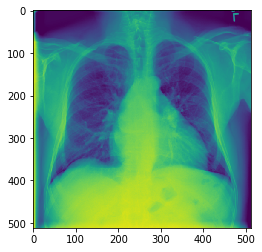

In [14]:
data = train_dataset[0]
image = data[0]
print("Size: ", image.shape)
plt.imshow(image[0])

## Model

In [15]:
model = Model().to(device)

In [16]:
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0)

In [17]:
_ = model.train(True) # Set to training mode

## Training

In [29]:
def weighted_BCELoss(output, target, weights=None):
    """Computes Weighted binary cross entropy loss."""
    # TODO: check this function thoroughly
    
    output = output.clamp(min=1e-5, max=1-1e-5)
    target = target.float()

    if weights is None or len(weights) != 2:
        weights = (1, 1)
        
    w1, w2 = weights
    loss = -w1 * target * torch.log(output) - w2 * (1 - target) * torch.log(1 - output)

    return torch.sum(loss)

In [27]:
# FIXME: this code is to calculate the loss of the bbox prediction,
# though the metric should be different? don't use binary cross entropy?

#     # Get valid bbox_list
#     # REVIEW: make bbox_list a tensor? and then send to device? same on seg_list below
#     bbox_list = []
#     n_samples, n_labels = bbox_valids.size()
#     for i in range(n_samples):
#         bbox_list.append([])
#         for j in range(n_labels):
#             if bbox_valids[i][j] == 1:
#                 bbox_list[i].append(bboxes[i][j])
#         bbox_list[i] = torch.stack(bbox_list[i]).to(device)
    
    
#     # Segmentation lists
#     seg_list = []
#     for i in range(n_samples):
#         seg_list.append([])
#         for j in range(n_labels):
#             if bbox_valids[i][j] == 1:
#                 seg_list[i].append(segments[i][j])
#         seg_list[i] = torch.stack(seg_list[i]).to(device)
    
#     # Compute bbox loss
#     for i in range(len(seg_list)):
#         # REVIEW: do this with a tensor? avoid the loop
#         loss += 5/(512*512) * weighted_BCELoss(seg_list[i], bbox_list[i], weights=(10, 1))
        
#         break
# #         print(seg_list[i].size())
# #         print(bbox_list[i].size())
# #         break

In [30]:
def train_iteration(data_instance, training=True):
    images, labels, names, _, _ = data_instance

    # Move tensors to GPU
    images = images.to(device)
    labels = labels.to(device)

    # Enable recording gradients # only on training
    torch.set_grad_enabled(training)
    
    # Calculate weights for loss
    n_samples, n_labels = labels.size()
    total = n_samples * n_labels
    positive = int((labels > 0).sum())
    negative = total - positive

    if positive != 0 and negative != 0:
        BP = total/positive
        BN = total/negative
        weights = (BP, BN)
    else:
        weights = None
        
    # zero the parameter gradients
    optimizer.zero_grad()

    # Forward, receive outputs from the model and segments (bboxes)
    outputs, segments = model(images)

    # Compute classification loss
    loss = weighted_BCELoss(outputs, labels, weights=weights)
    
    if training:
        loss.backward()
        optimizer.step()
        print(loss.item())

    return

def train(dataloader, training=True):
    for data in dataloader:
        train_iteration(data, training=training)
        
train(train_dataloader)

41.07262420654297
45.83076858520508
42.53499984741211
43.35528564453125
46.24311065673828
43.029666900634766
44.9226188659668
46.62489318847656
45.828590393066406
47.17210388183594
43.49398422241211
5.532693862915039


In [20]:
train_dataset.size()

(45, 15)